## The Computer-Vision Recommender 
### This recommender generates embeddings for images and compares the Euclidean distances between images to find similarities

#### It could be used in addition to NLP-based recommenders when:
1. The query image/object is out of sample
2. Cold start problem
3. When no text input is available about the product
4. This model is completely unsupervised.

#### In this example we use the Turi Create library, Turi Create simplifies the development of custom machine learning models, so the development is faster!
https://github.com/apple/turicreate


#### The movie recommender example:
Here, instead of using NLP on text (movie plot, descriptions, etc) to compare cosine similarities, we use movie posters as images rendered to vectors, we use image embeddings to compare their distances to each others.

#### Let's find out which recommender is better!

In [ ]:
#Load libraries

from IPython.display import display
from IPython.display import HTML
from PIL import Image
from io import BytesIO
import glob
import random
import base64
import pandas as pd

import mxnet as mx
import turicreate as tc

In [618]:
# Load Movie posters from the downloaded data
reference_data  = tc.image_analysis.load_images('./SampleMoviePosters/New')
reference_data = reference_data.add_row_number()

In [619]:
reference_data['label'] = reference_data['path'].apply(lambda path: path.split('/')[6])

In [620]:
#Take a look of the movie posters we have!
reference_data.groupby('label', [tc.aggregate.COUNT]).sort("Count", ascending = False)

label,Count
New,541


In [621]:
reference_data.save('./caltech-101.sframe')

In [622]:
reference_data.head()

id,path,image,label
0,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 1500 Width: 1012,New
1,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 1500 Width: 1052,New
2,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 1440 Width: 972,New
3,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 755 Width: 499,New
4,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 755 Width: 488,New
5,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 586 Width: 364,New
6,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 740 Width: 495,New
7,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 1500 Width: 2000,New
8,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 1500 Width: 2000,New
9,/Users/anis/Documents/recommender/SampleMovieP ...,Height: 3000 Width: 2024,New


In [623]:
#we write some functions to process the images for our model
def get_thumbnail(path):
  i = Image.open(path)
  i.thumbnail((250, 250), Image.LANCZOS)
  return i
  
def get_thumbnail_from_image(img):
  i = img.copy()
  i.thumbnail((250, 250), Image.LANCZOS)
  return i

def image_base64(im):
  if isinstance(im, str):
    im = get_thumbnail(im)
  with BytesIO() as buffer:
    im.save(buffer, 'jpeg')
    return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
  return f'<img style="display:inline;margin:1px" src="data:image/jpeg;base64,{image_base64(im)}">'
  
def preview_images(reference_data, num_previews=30):
  images = list(map(lambda x:image_formatter(get_thumbnail(x)), reference_data[0:num_previews]['path']))
  display(HTML(''.join(images)))


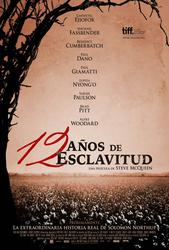
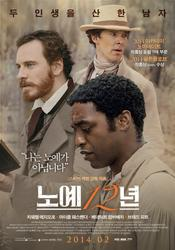
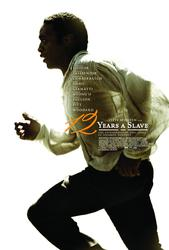
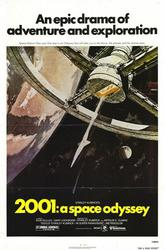
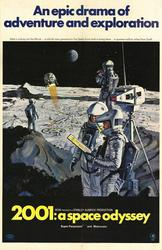
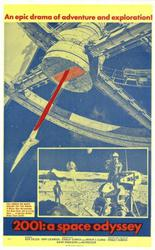
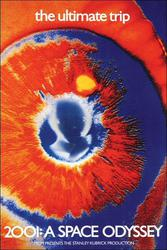
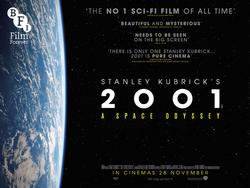
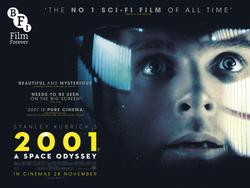
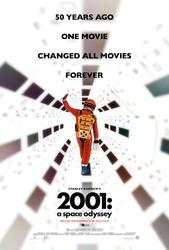

In [624]:
preview_images(reference_data, 10)

In [625]:
model = tc.image_similarity.create(reference_data)

Using GPU (AMD Radeon Pro 555X) to extract features.

Analyzing and extracting image features.

+------------------+--------------+------------------+

| Images Processed | Elapsed Time | Percent Complete |

+------------------+--------------+------------------+

| 64               | 1.45s        | 11%              |

| 128              | 3.02s        | 22%              |

| 192              | 4.09s        | 33.25%           |

| 256              | 5.15s        | 44.25%           |

| 320              | 6.22s        | 55.5%            |

| 541              | 10.47s       | 100%             |

+------------------+--------------+------------------+

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Downloading https://takisjpepescripts.files.wordpress.com/2020/05/sigourney-weaver-aliens.jpg to /var/folders/xf/0x5f38g516q1vvq4j38t7vx40000gn/T/turicreate-anis/4874/62a639bd-9f48-4b34-a90e-72839c5a2efd.jpg

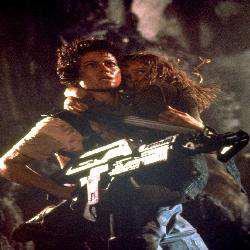

In [630]:
#Let's find out how good is the model in identifying/reccommending movies from a movie still

image_url = "https://takisjpepescripts.files.wordpress.com/2020/05/sigourney-weaver-aliens.jpg"
sample_image = tc.Image(image_url)
sample_image_thumb = tc.image_analysis.resize(sample_image, 250, 250)
sample_image_thumb.save("sample_image_thumb.jpg")
sample_image_thumb_pil = Image.open("sample_image_thumb.jpg")
display(sample_image_thumb_pil)

In [633]:
# query_results = model.query(reference_data[sample_index:sample_index+1], k=20)
query_results = model.query(sample_image, k=5)
query_results.head()

Analyzing and extracting image features.

+------------------+--------------+------------------+

| Images Processed | Elapsed Time | Percent Complete |

+------------------+--------------+------------------+

| 1                | 761.727ms    | 100%             |

+------------------+--------------+------------------+

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.184843    | 11.461ms     |

| Done         |         | 100         | 47.398ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,173,18.60632645376742,1
0,176,19.054328550568982,2
0,260,19.0628067816169,3
0,167,19.255812170323292,4
0,321,19.495841861868158,5



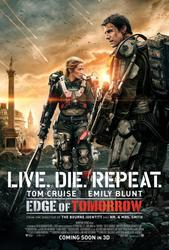
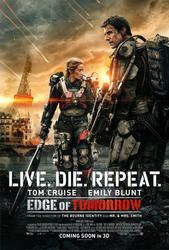
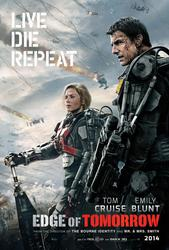
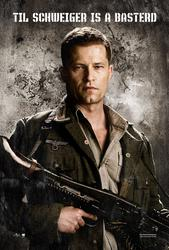
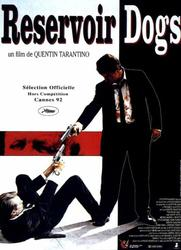

In [634]:
# get k most "similar" looking images
similar_rows = query_results[query_results['query_label'] == 0]['reference_label']
similar_rows_data = reference_data.filter_by(similar_rows, 'id')
preview_images(similar_rows_data)

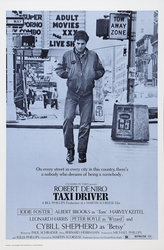

In [636]:
# sample an image from the reference_data
sample_index = 345
sample_image_path = reference_data[sample_index]['path']
sample_image = Image.open(sample_image_path)
display(get_thumbnail(sample_image_path))

In [637]:
similarity_graph = model.similarity_graph(k=10)
similar_images = similarity_graph.edges

Starting blockwise similarity graph construction.

max rows per data block: 6207

number of reference data blocks: 12

+---------+-------------+--------------+

| # Pairs | % Complete. | Elapsed Time |

+---------+-------------+--------------+

| 12195   | 7.38876     | 38.674ms     |

| 165048  | 100         | 404.245ms    |

+---------+-------------+--------------+

In [639]:
sample_similar_images = similar_images[similar_images["__src_id"]==sample_index].sort('rank')
sample_similar_images

__src_id,__dst_id,distance,rank
345,478,15.976821940703871,1
345,303,16.468349126775745,2
345,122,16.955874722819942,3
345,227,17.059790444149076,4
345,294,17.098986692676032,5
345,304,17.633447331189743,6
345,434,17.639712715069162,7
345,309,17.68813031531718,8
345,47,17.703415016732407,9
345,321,17.781122342618268,10



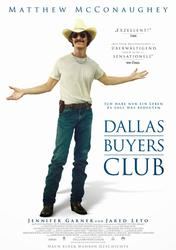
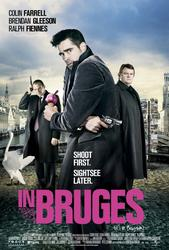
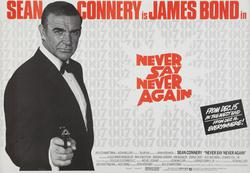
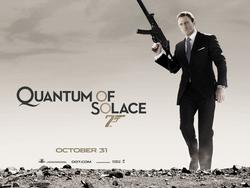
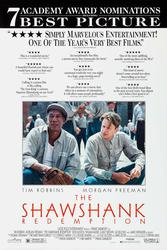

In [640]:
dst_ids = sample_similar_images["__dst_id"][0:5]
ref_similar_images = reference_data.filter_by(dst_ids, 'id')
preview_images(ref_similar_images)

In [516]:
# saving the model
model.save('./image_similarity.model')
loaded_model = tc.load_model('./image_similarity.model')